In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from data_functions import *
from metric_functions import *
from helper_functions import *
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Finałowy model

- Zredukowana augumentacja przez niedotrenowanie
- Wykorzystanie najlepszego modelu z eksperymentów

In [2]:
dataset = torch.load("reduced_data.tar")
train, val = trai_val_split(dataset, 0.8)

In [3]:
net_final = CustomNet(64, 50, 120, 3, 32, 7, 2, 2)
net_final.to(device)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_final.parameters(), lr=0.001)

In [4]:
loss_hist, train_eval_hist, val_eval_hist = train_model(net_final, train_loader, val_loader, criterion, optimizer, get_accuracy, device=device, num_epochs=50)

100%|██████████| 50/50 [14:02<00:00, 16.86s/it]


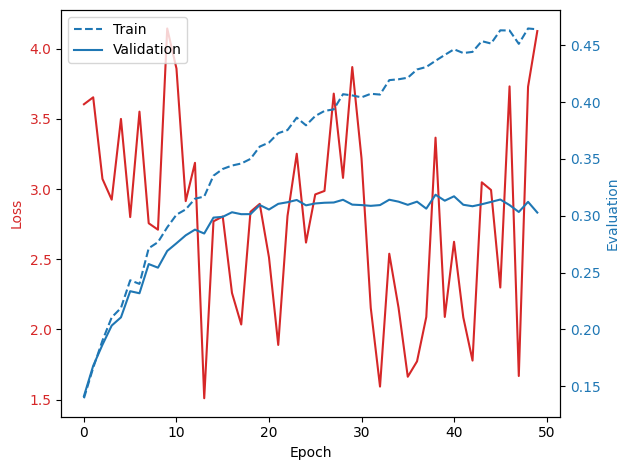

In [5]:
plot_training([i for i in range(50)], loss_hist, train_eval_hist, val_eval_hist)

In [6]:
torch.save(net_final, "final_model.tar")

## Ewaluacja

Balanced accuracy: 0.29992324113845825
Final accuracy: 0.30278929727887294


/tmp/ipykernel_294042/2558907769.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")


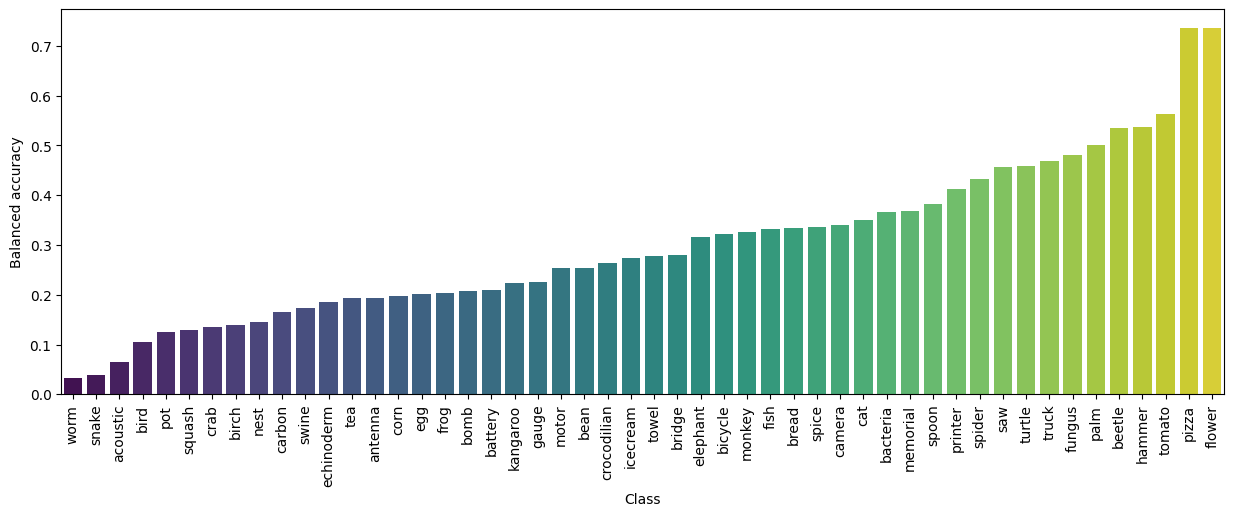

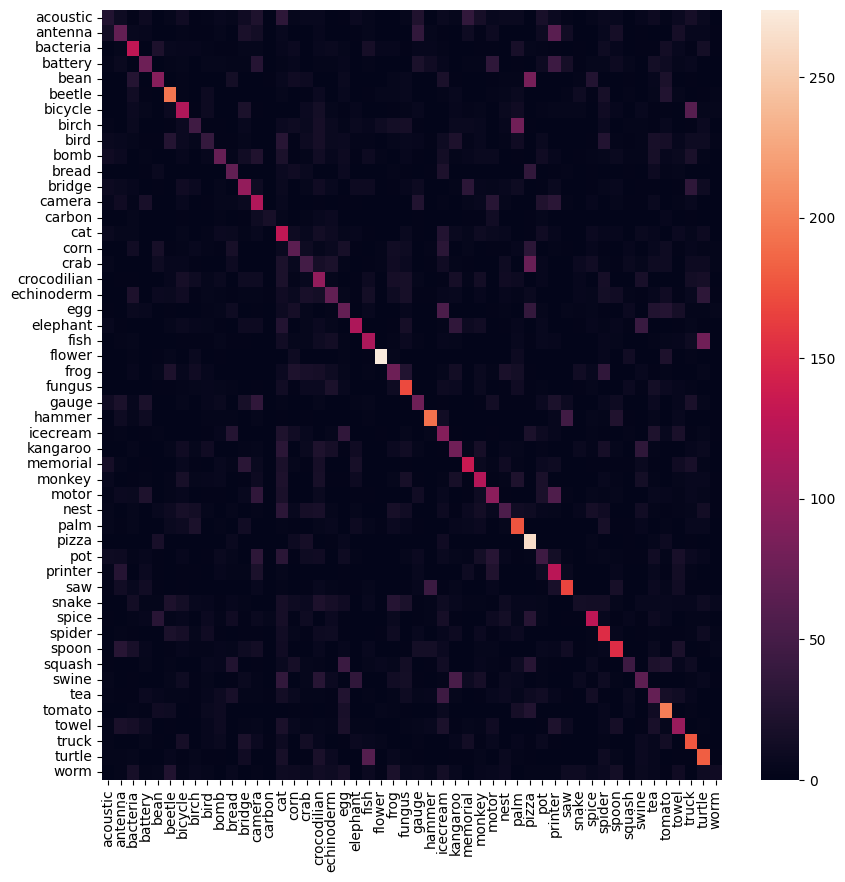

In [7]:
labels = ['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']
balanced_accuracy_score, balanced_accuracy = get_balanced_accuracy(net_final, classes=labels, data=val_loader, device=device)
print(f"Balanced accuracy: {balanced_accuracy_score}")
final_acc = get_accuracy(net_final, val_loader, device)
print(f"Final accuracy: {final_acc}")
fig, ax = plt.subplots(figsize=(15, 5))
label_score = {label: score for label, score in zip(labels, balanced_accuracy.numpy())}
label_score_sorted = {k: v for k, v in sorted(label_score.items(), key=lambda item: item[1])}
sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")
plt.ylabel("Balanced accuracy")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.show()
confusion_matrix = get_confusion_matrix(net_final, val_loader, classes=labels, device=device) 
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

## Predykcje

In [10]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_path = "./test_all"
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform, is_valid_file=lambda x: True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

net_final.eval()
predictions = []
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net_final(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())

filenames = [f[0].split("/")[-1].upper() for f in test_loader.dataset.imgs]
df = pd.DataFrame({"Filename": filenames, "Prediction": predictions})
df.to_csv("predictions.csv", index=False)